# Time Series Analysis

G. Richards
(2016, 2018, 2020)
with materials from Connolly and Ivezic Chapter 10 (skipping 10.2.2-10.2.5).

# Pre-Lecture Items

- install:
```
pip install gatspy
```

From [http://www.astroml.org/gatspy/](http://www.astroml.org/gatspy/):

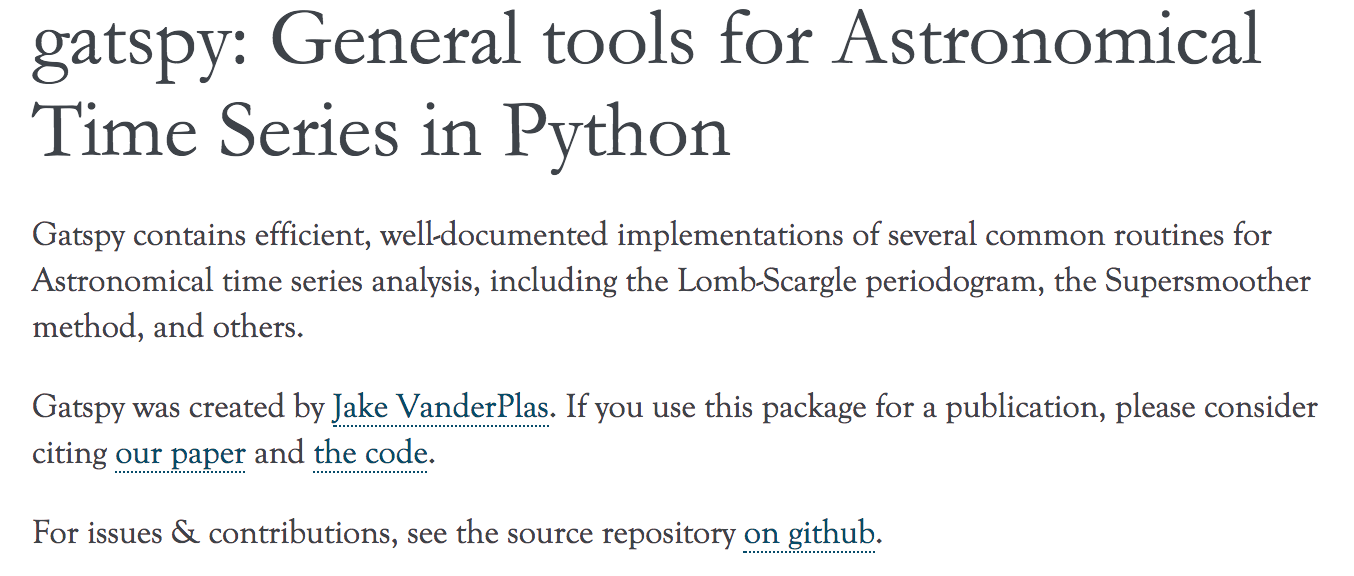

Time series analysis is, in many ways, very similar to regression analysis from Chapter 8, except that we replace $x$ with $t$.  However, we have generally assumed that the $y$ values are independent, whereas for time series $y_{i+1}$ is likely to depend directly on $y_i$.  Furthermore, we make no assumptions about the regularity of the time sampling.

There is a broad range of variability signatures that we want to be aware of. From transient events to periodic variables to stochastic sources.

Eyer and Mowlavi (2007, arXiv:0712.3797) 

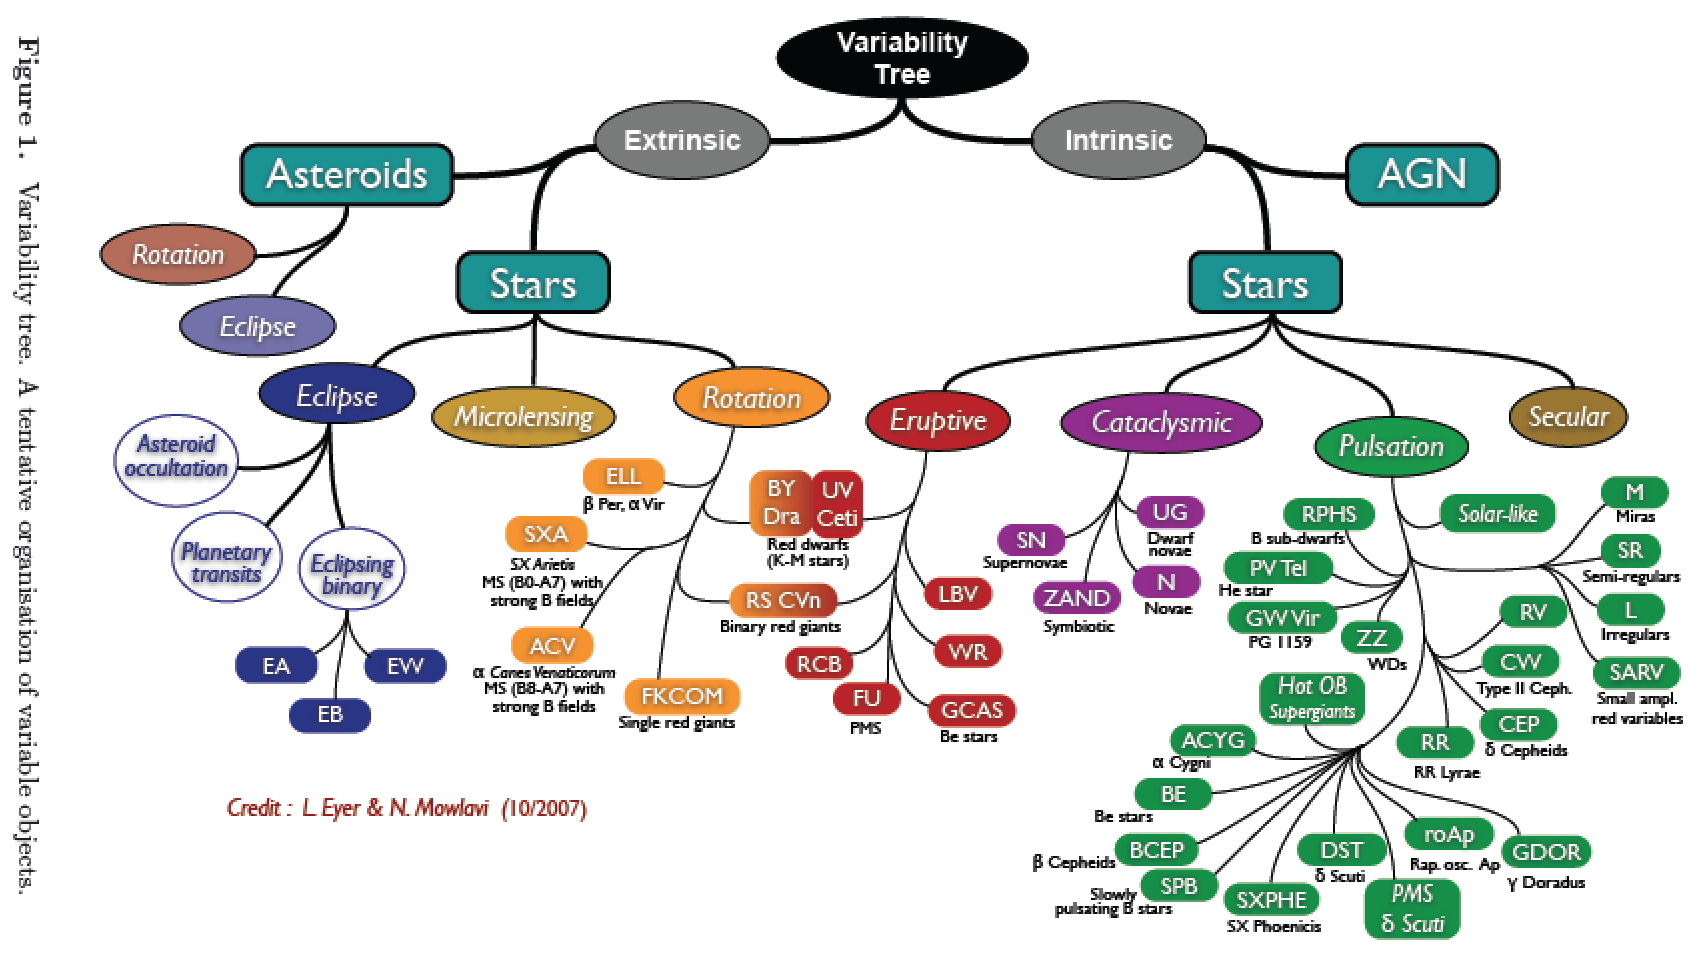

Here are examples of three different types of variable sources.  First, a flaring star.  Second, a periodically variable star (which has a fixed period).  Third, an eclipsing binary star (which has a two-step cycle).

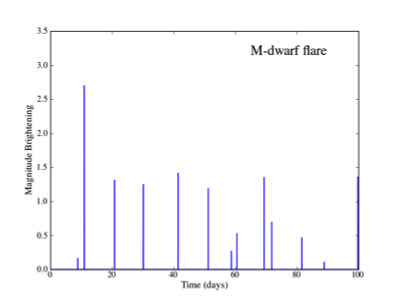
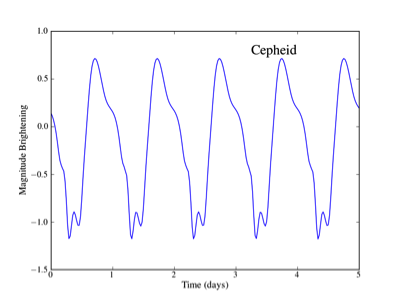
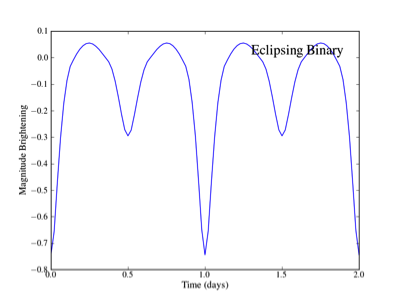

## Goals

When dealing with time series data, the first thing that we want to know is if the system that we are studying is even variable (otherwise, there is no point doing time series analysis!).  In the context of frequentist statistics, this is a question of whether our data would have been obtained by chance if the no-variability null hypothesis were correct.

If we find that our source *is* variable, then our time-series analysis has two main goals:
1. Characterize the temporal correlation between different values of $y$ (i.e., characterize the "light curve").  For example by learning the parameters for a model.
2. Predict future values of $y$.

If the errors are known and Gaussian, we can simply compute $\chi^2$ and the corresponding $p$ values for variation in a signal.

For a sinusoidal variable signal
    $$ y(t) = A \sin(\omega t)$$
with constant errors, $\sigma$, then
variance is $V = \sigma^2 + A^2/2$.
    
If $A=0$ (no variability, with $\overline{y}=0$)
- $\chi^2_{\rm dof}=N^{-1} \sum_j (y_j/\sigma)^2 \sim V/\sigma^2$.
- $\chi^2_{\rm dof}$ has  expectation value of 1 and std dev  of $\sqrt{2/N}$

If $|A|>0$ (variability)
- $\chi^2_{\rm dof}$ will be larger
than 1. 
-  probability that $\chi^2_{\rm dof}>1 + 3 \sqrt{2/N}$  is about 1 in 1000 (i.e., $>3\sigma$ above 1, where $3\sigma$ is 0.997).

If this false-positive rate is acceptable (because even without variability 1 in 1000 will be above this threshold) then the minimum detectable amplitude is $A > 2.9 \sigma
/ N^{1/4}$ ( from $V/\sigma^2=1 + 3 \sqrt{2/N}$, so that $A^2/2\sigma^2 = 3 \sqrt{2/N}$).

N.B. Depending on how big your sample is, you may want to choose a higher threshhold.    E.g., for 1 million non-variable stars, this criterion would identify 100 as variable!

For $N=100$ data points (not 100 objects), the minimum detectable amplitude is $A=0.92\sigma$

For $N=1000$, $A = 0.52\sigma$ 

That is, if we have enough data points, we can actually detect variability whose amplitude is smaller than the uncertainty in the measurements.

Note that this is the best that we can do under the assumption of the null hypothesis of no variability.  If instead we know the model (not limited to periodic variability), then we can perform a [**"matched filter"**](https://en.wikipedia.org/wiki/Matched_filter) analysis and improve upon this (i.e., we can positively identify lower-amplitude variability).  Indeed in a Bayesian analysis, we must have a model in mind.

For non-periodic variability, the system can either be **stochastic** (like the stock market) or **temporally localized** (such as a flare/burst).

## Parameter Estimation, Model Selection, and Classification

Time series analysis can be conducted in either the time domain or the frequency domain.  We'll first start with a discussion of the time domain by revisiting tools that we have already discussed like parameter estimation and regression.

We can fit a model to $N$ data points $(t_i,y_i)$:

$$y_i(t_i) = \sum_{m=1}^M \beta_m T_m(t_i|\theta_m) + \epsilon_i,$$

where the functions, $T_m$, do not need to be periodic, $t_i$ does not need to be evenly sampled and $\theta_m$ are the model parameters.

Common deterministic models include
$$T(t) = \sin(\omega t)$$
and
$$T(t) = \exp(-\alpha t),$$
where the frequency, $\omega$, and decay rate, $\alpha$, are parameters to be estimated from the data.

We will also explore a so-called "chirp" signal with
$$T(t) = \sin(\phi + \omega t + \alpha t^2).$$


(another way of thinking of a chirp is that the *frequency varies with time*; $\omega_{\rm instantaneous} = \omega + \alpha t$)

So, for example, if we have
$$y_i(t_i) = a \sin(\omega_0 t_i) + b \cos (\omega_1 t_i),$$
then $a=\beta_0$, $b=\beta_1$, $\omega_0=\theta_0$, and $\omega_1 = \theta_1$.

So, this is basis function regression where $\sin$ and $\cos$ are the basis functions.

Determining whether a variable model is favored over a non-variable model is the same as we have dealt with previously and can also be approached using the AIC, BIC, or Bayesian odds ratio.  Once the model parameters, $\theta_m$ have been determined, we can apply supervised or unsupervised classification methods to gain further insight.

## Fourier Analysis

Fourier Analysis has the potential to be the subject for an entire class as opposed to part of a single lecture. 

The code below demostrates an application that you are likely familiar with: reconstruction of a complicated signal by summation of simpler trig functions:

$$y_i(t_i) = Y_o + \sum_{m=1}^M \beta_m \sin(m \omega t_i + \phi_m)   + \epsilon_i.$$

Note: **any** periodic function can be described within noise with a sufficiently large M! 

In [ ]:
# Ivezic v2, Figure 10.1, edits by GTR
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_rrlyrae_templates

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

#------------------------------------------------------------
# Load the RR Lyrae template
templates = fetch_rrlyrae_templates()
x, y = templates['115r'].T

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0)

kvals = [1, 3, 8]
subplots = [311, 312, 313]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    y_fft = np.fft.fft(y)
    y_fft[k + 1:-k] = 0
    y_fit = np.fft.ifft(y_fft).real

    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2)
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='gray')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    ax.text(0.02, 0.1, label, ha='left', va='bottom',
            transform=ax.transAxes)

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[1]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(0, 2)
    ax.set_ylim(1.1, -0.1)

plt.show()

The Fourier Transform can be powerful if the signal-to-noise is high, but if not or if the signal has a complex shape or is irregularly sampled, then a probabilistic approach is better.  In astronomy, that is often the situation that we find ourselves in.  So, I'll leave the details for you to read about in $\S$ 10.2 and we'll skip ahead.

## Temporally Localized Signals ($\S$ 10.4)

Let's look at the case of a stationary signal with an event localized in time.
An example would be the signature of a [gravitational wave from LIGO](https://www.ligo.caltech.edu/news/ligo20160615).

In this case we know the expected shape of the signal and the noise properties are understood, so we can do what is called *forward modeling*.  Specifically, we can identify the signal by using a **matched filter** (with MCMC to search for the parameter covariances).

Even if we didn't know the shape of the distribution, we could use a non-parametric form to perform matched filter analysis.  Furthermore, for complex signals we can marginalize over "nuisance" parameters (e.g. start time or phase) that are not important for our model.

## Finding a chirp or burst in a time series

Imagine a stationary signal $y(t)=b_0+\epsilon$ with an injected signal at time $T$ (possibly followed by a decay to the original level $b_0$ over some unknown time period).

This injected signal could be a "burst"

$$y(t)=b_0 + A\exp[−\alpha(t−T)]$$ (exponential decay after a sharp increase at $t=T$

or a ["chirp"](https://en.wikipedia.org/wiki/Chirp)

$$y(t)=b_0+A \sin[\omega t+\beta t^2]$$

(a periodic signal where the frequency changes with time).

Below are examples of using MCMC to fit both a burst signal and a chirp signal.  Try changing the parameters such that the system is 1) very well modeled and 2) very poorly modeled.

In [ ]:
# Ivezic v2, Figure 10.25, edits by GTR
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm

from astroML.plotting.mcmc import plot_mcmc
from astroML.utils.decorators import pickle_results

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)


# ----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    mask = (t >= T)
    y = b0 + mask * A * np.exp(-alpha * (t - T))
    return y


np.random.seed(0)


#See what happens when you change these.
#But don't pick values outside the limits searched by the MCMC
N = 100
b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 50
sigma = 1.0

t = 100 * np.random.random(N)

y_true = burst(t, b0_true, A_true, alpha_true, T_true)
y_obs = np.random.normal(y_true, sigma)


# ----------------------------------------------------------------------
# Set up and run the MCMC sampling
# We need to wrap it in a function in order to be able to pickle the result
@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(draws=3000, tune=1000):
    with pm.Model():
        #Limits of MCMC model
        b0 = pm.Uniform('b0', 0, 50)
        A = pm.Uniform('A', 0, 50)
        T = pm.Uniform('T', 0, 100)
        log_alpha = pm.Uniform('log_alpha', -10, 10)

        y = pm.Normal('y', mu=burst(t, b0, A, np.exp(log_alpha), T),
                      sd=sigma, observed=y_obs)

        traces = pm.sample(draws=draws, tune=tune)

        return traces


traces = compute_MCMC_results()
mean_vals = pm.summary(traces)['mean']
mean_vals['alpha'] = np.exp(mean_vals.pop('log_alpha'))

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']

limits = [(9.2, 11.2), (2, 12), (45, 55), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['b0', 'A', 'T']] + [np.exp(traces['log_alpha'])],
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = burst(t_fit, **mean_vals)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.plot(t_fit, y_fit, '-k')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()

In [ ]:
# Ivezic v2, Figure 10.26, edits by GTR
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm

from astroML.plotting.mcmc import plot_mcmc

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots

setup_text_plots(fontsize=12, usetex=True)


# ----------------------------------------------------------------------
# Set up toy dataset
def chirp(t, b0, beta, A, omega):
    return b0 + A * np.sin(omega * t + beta * t * t)


np.random.seed(0)

#See what happens when you change these.
#But don't pick values outside the limits searched by the MCMC
N = 100
#N = 1000
b0_true = 10
A_true = 5
beta_true = 0.01
omega_true = 0.1
#omega_true = 0.5
sigma = 2.0

t = 100 * np.random.random(N)

y_true = chirp(t, b0_true, beta_true, A_true, omega_true)
y_obs = np.random.normal(y_true, sigma)


# ----------------------------------------------------------------------
# Set up MCMC sampling
with pm.Model():
    #Limits of MCMC model
    b0 = pm.Uniform('b0', 0, 50, testval=50 * np.random.random())
    A = pm.Uniform('A', 0, 50, testval=50 * np.random.random())
    log_beta = pm.Uniform('log_beta', -10, 10, testval=-4.6)
    log_omega = pm.Uniform('log_omega', -10, 10, testval=-2.3)

    y = pm.Normal('y', mu=chirp(t, b0, np.exp(log_beta), A, np.exp(log_omega)),
                  sd=sigma, observed=y_obs)

    # Choose the Metropolis-Hastings step rather than rely on the default
    step = pm.Metropolis()
    traces = pm.sample(draws=5000, tune=2000, step=step)


# ----------------------------------------------------------------------
# Use the summary() function to provide statistics for each variable
mean_vals = pm.summary(traces)['mean']
mean_vals['omega'] = np.exp(mean_vals.pop('log_omega'))
mean_vals['beta'] = np.exp(mean_vals.pop('log_beta'))

labels = ['$b_0$', '$A$', r'$\omega$', r'$\beta$']
limits = [(9.5, 11.3), (3.6, 6.4), (0.065, 0.115), (0.00975, 0.01045)]
true = [b0_true, A_true, omega_true, beta_true]

fig = plt.figure(figsize=(10, 10))
ax = plt.axes([0.5, 0.7, 0.45, 0.25])

t_fit = np.linspace(0, 100, 1001)
y_fit = chirp(t_fit, **mean_vals)


# ----------------------------------------------------------------------
# Plot multiple panels with the traces
plt.scatter(t, y_obs, s=9, lw=0, c='k')
plt.plot(t_fit, y_fit, '-k')
plt.xlim(0, 100)
plt.xlabel('$t$')
plt.ylabel(r'$h_{\rm obs}$')

plot_mcmc([traces[ii] for ii in ['b0', 'A']]
          + [np.exp(traces['log_omega']), np.exp(traces['log_beta'])],
          labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, bounds=[0.12, 0.08, 0.95, 0.91], colors='k')
plt.show()

## Periodic signals ($\S$ 10.3)

Many systems have **periodic** signals.  This is especially true in astronomy (e.g., RR-Lyrae, Cepheids, eclipsing binaries).

What we want to be able to do is to detect variability and measure the period and amplitude in the face of both noisy and incomplete data.

If the data well-sample the process (high "cadence" relative to the period), then determining the parameters of the process is easy.  If the data are not well sampled, the jobs is harder (but still possible!).

For example, the figure on the top is the kind of data that you *want* to have, whereas the figure on the bottom is the kind of data that you are more likely to have.

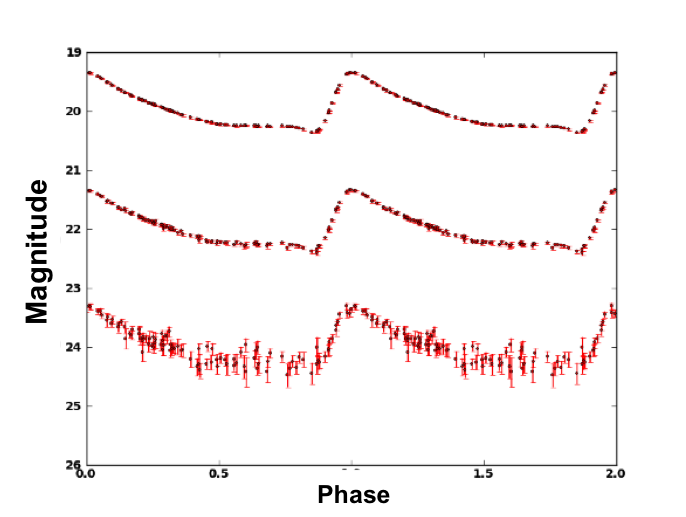
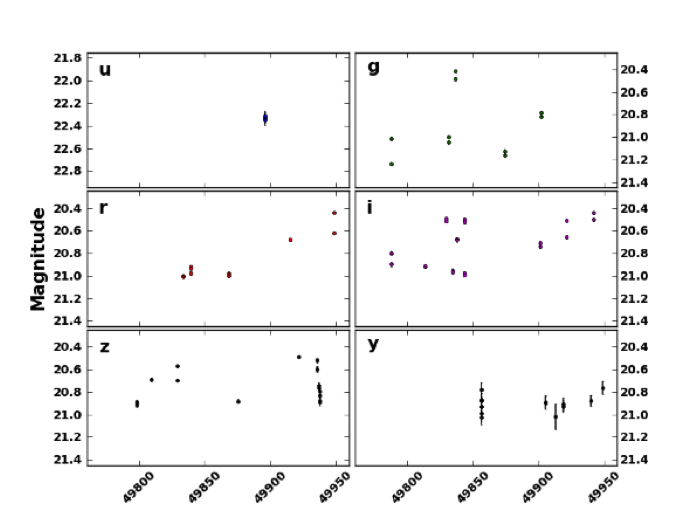

<img src="figures/rrlyrae-good.png" style="float: left; width: 40%; margin-right: 1%;"> <img src="figures/rrlyrae-bad.png" style="float: left; width: 40%; margin-right: 1%;">

For a periodic signal we have:

$$y(t+P)=y(t),$$ where $P$ is the period.

We can create a *phased light curve* that plots the data as function of phase:
$$\phi=\frac{t}{P} − {\rm int}\left(\frac{t}{P}\right),$$

where ${\rm int}(x)$ returns the integer part of $x$.

For example in the case below, when the pattern starts to repeat, we reset the $t$ axis to 0:
![Eclipsing Binary](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Light_curve_of_binary_star_Kepler-16.jpg/800px-Light_curve_of_binary_star_Kepler-16.jpg)

### A Single Sinusoid

Let's take the case where the data are drawn from a single sinusoidal signal:

$$y(t)=a \sin(\omega t)+b \cos(\omega t),$$

where $A=(a^2+b^2)^{1/2}$ and $\phi=\tan^{−1}(b/a)$

and determine whether or not the data are indeed consistent with periodic variability and, if so, what is the period.

Assuming constant uncertainties on the data, the likelihood for this model becomes,

$$L\equiv p({t,y}|\omega,a,b,\sigma)=\prod^N_{j=1}\frac{1}{\sqrt{2π}\sigma} \exp \left(\frac{−[y_j−a \sin(\omega t_j)−b \cos(\omega t_j)]}{2\sigma^2} \right), $$

where $y_i$ is the measurement (e.g., the brightness of a star) taken at time $t_i$.

The posterior can be simplified to

$$p(\omega|\{t,y\}, \sigma) \propto \sigma^{−N} \exp \left(\frac{−NQ}{2\sigma^2} \right) \propto \exp \left(\frac{P(\omega)}{\sigma^2} \right).$$


where $P(\omega)$ is the [periodogram](https://en.wikipedia.org/wiki/Periodogram), which is just a plot of the "power" at each possible period (as illustrated below):

The "best value" $\omega$ is given by

$$\chi^2(\omega) =  \chi_0^2 \, \left[1 - {2 \over N \, V}  \, P(\omega) \right],$$

where $P(\omega)$ is the periodogram and $\chi_0^2$ is the $\chi^2$ for a model with $y(t)$=constant:

$$  \chi_0^2 = {1 \over \sigma^2} \sum_{j=1}^N y_j^2 = {N \, V \over \sigma^2}$$

We renormalise the periodogram, defining the [Lomb-Scargle periodogram](https://en.wikipedia.org/wiki/Least-squares_spectral_analysis#The_Lomb.E2.80.93Scargle_periodogram) as

$$P_{\rm LS}(\omega) = \frac{2}{N V} P(\omega),$$  where $0 \le P_{\rm LS}(\omega) \le 1$.

With this renormalization, the ratio of $\chi^2(\omega)$ (for the periodic model) 
relative to $\chi^2_0$ (for the pure noise model) is
$${\chi^2(\omega) \over \chi^2_0}=  1 - P_{LS}(\omega).$$

So, to determine if our source is variable or not, we first compute $P_{\rm LS}(\omega)$ and then model the odds ratio for our variability model vs. a no-variability model.

If our variability model is "correct", then the peak of $P(\omega)$ [found by grid search] gives the best $\omega$.

Below is an example of a LS periodogram generated using 100 points drawn from $y(t|P) = 10 + \sin(2\pi t/P),$ with $P=0.3$.  

[http://www.astroml.org/gatspy/periodic/lomb_scargle.html](http://www.astroml.org/gatspy/periodic/lomb_scargle.html) gives more information on astroML's implementation.

In [ ]:
# Ivezic v2, Figure 10.15, edits by GTR (see UW AST324)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
#GTR: Need to switch to this, but have't figured out the details yet.
#from astropy.timeseries import LombScargle

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

#------------------------------------------------------------
# Generate Data
np.random.seed(0)
N = 100
P = 0.3

t = np.random.randint(100, size=N) + 0.3 + 0.4 * np.random.random(N)
y = 10 + np.sin(2 * np.pi * t / P)
dy = 0.1 + 0.1 * np.random.random(N)
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# Compute periodogram
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period
PS = lomb_scargle(t, y_obs, dy, omega, generalized=True)

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True, N_bootstraps=1000, random_state=0)
#GTR: Need to switch to this, but have't figured out the details yet.
#D = LombScargle(t, y_obs, dy, omega, generalized=True, N_bootstraps=1000, random_state=0)
sig1, sig5 = np.percentile(D, [99, 99.9])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.35)

# First panel: the data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.set_xlim(-5, 105)

# Second panel: the periodogram & significance levels
ax1 = fig.add_subplot(212, xscale='log')
ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black')
ax1.plot([period[0], period[-1]], [sig5, sig5], ':', c='black')

ax1.annotate("", (0.3, 0.65), (0.3, 0.85), ha='center',
             arrowprops=dict(arrowstyle='->'))

ax1.set_xlim(period[0], period[-1])
ax1.set_ylim(-0.05, 0.85)

ax1.set_xlabel(r'period (days)')
ax1.set_ylabel('power')

# Twin axis: label BIC on the right side
ax2 = ax1.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_locator(plt.LogLocator(10))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

plt.show()

If that isn't impressive, try changing the period to 5-10 days and the number of points to 200-300 (you'll need to increase `period` array as appropriate, note that it is a log quantity) to compare this to a situation that is more obvious.  Now are you impressed?

### False Alarm Probability

The **false alarm probability** tells us “what is the probability that a signal with no periodic component would lead to a peak of this magnitude?” (VanderPlas 2017, [arXiv:1703.09824](https://arxiv.org/abs/1703.09824)), but what we want to know is instead “what is the probability that this dataset is periodic given these
observations?”, which is 

$$ {p(Var\,|\,Peak) \over p(Const\,|\,Peak)} = {1 \over FAP} \, {p(Var) \over p(Const)}. $$

In order to have a reliable detection of the period we want the odds ratio on the LHS $>$10,  Then depending on the ratio of priors [p(Var)/p(Const)], we determine the required FAP.

The two horizontal dashed lines in the periodogram above correspond to FAPs of
0.01 and 0.001 (computed from bootstrap resampling).

### Aliasing

But why did we have 3 peaks above the line FAP=0.001??? 

The two most common problems are sampling aliases (e.g. observations spaced 
by roughly 1 day) and inability of a single sinusoid to fit the shape of light
curve (always check if there is another significant peak at twice the best-fit 
period). 

For details see Section 7.2 in "Understanding the Lomb-Scargle Periodogram" 
by Jake VanderPlas (2017, [arXiv:1703.09824](https://arxiv.org/abs/1703.09824)). 

### Generalized Lomb-Scargle

The Lomb-Scargle periodogram is a fit to a model:

$$y(t)=a \sin(\omega t)+b \cos(\omega t),$$

whose mean is zero. In reality, the observed variability is typically around some (mean) value, not zero. We deal with this by subtracting the mean of the sample $\overline{y}$ from the data before performing the periodogram analysis.

That only works if $\overline{y}$ is a good estimator of the mean of the distribution, $y(t)$ -- if the data is equally sampled at all phases. However, in practice, the data may not equally sample all of the phases.

For example, consider the case of a star that has a period of one day and the fact that a single optical telescope only takes data at night. In that case you we might get something like the top panel below:

![Ivezic, Figure 10.16](http://www.astroml.org/_images/fig_LS_sg_comparison_3.png)


The "generalized" Lomb-Scargle approach (also implemented in astroML) can help with this as can be seen in the bottom panel above. It fits the model with non-zero mean:

$$y(t)=a \sin(\omega t)+b \cos(\omega t) + C$$

See also [Figure 10.16](http://www.astroml.org/book_figures/chapter10/fig_LS_sg_comparison.html) in the textbook (and note the erratum!).

### Multiband LS periodograms

Related to this is that one of the issues that we are going to be dealing with in astronomy over the next decade as the LSST project comes online is the problem of sparsely-sampled light curves, but with multiple light curves for each object -- one for each "bandpass" as seen below:

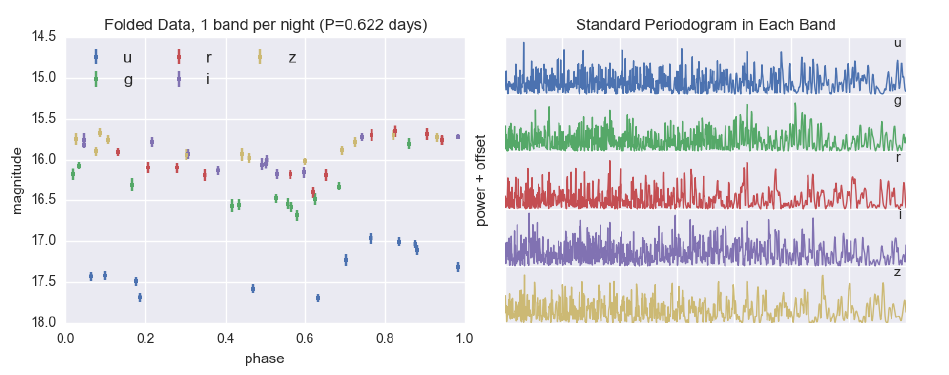

<img src="figures/multibandLS.png" style="float: right; width: 100%; margin-right: 1%;">

The generalized LS was an extension to account for the mean value. We can build on this to account for multiple bands by fitting for a global period and a per-band period

$\begin{eqnarray}
  &y_k(t|\omega,\theta) =
  \theta_0 + \sum_{n=1}^{N_{base}} \left[\theta_{2n - 1}\sin(n\omega t) + \theta_{2n}\cos(n\omega t)\right] +&\nonumber
  &\theta^{(k)}_0 + \sum_{n=1}^{N_{band}} \left[\theta^{(k)}_{2n - 1}\sin(n\omega t) + \theta^{(k)}_{2n}\cos(n\omega t)\right].&
\end{eqnarray}$

(Actually this illustrates a global offset and per-band offsets and not periods.)

The total number of parameters for $K$ filters is then $M_K = (2N_{base} + 1) + K(2N_{band} + 1)$. 

To keep the parameters constrained we apply regularization (see regression).

The important feature of this model is that _all bands_ share the same base parameters, $\theta$, while their offsets $\theta^{(k)}$ are determined individually.

Below we show the multi-band light curves of an RR Lyrae star as an example.  

A fit with just one base term isn't so great:

In [ ]:
from gatspy.datasets import fetch_rrlyrae
rrlyrae = fetch_rrlyrae()
lcid = rrlyrae.ids[0]

t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
period = rrlyrae.get_metadata(lcid)['P']

from gatspy.periodic import LombScargleMultiband
model = LombScargleMultiband(Nterms_base=1, Nterms_band=0)
model.fit(t, y, dy, filts)
periods = np.linspace(period - 0.1, period + 0.1, 2000)
power = model.periodogram(periods)

def plot_model(model, lcid):
    t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
    model.fit(t, y, dy, filts)
    
    tfit = np.linspace(0, period, 1000)
    for filt in 'ugriz':
        mask = (filts == filt)
        eb = plt.errorbar(t[mask] % period, y[mask], dy[mask], fmt='.', label=filt)
        yfit = model.predict(tfit, filt, period=period)
        plt.plot(tfit, yfit, color=eb[0].get_color())
    plt.gca().invert_yaxis()
    plt.legend(ncol=3, loc='upper left')
    
fig = plt.figure(figsize=(10,10))
plot_model(LombScargleMultiband(Nterms_base=1, Nterms_band=0), lcid)

But with 4 base terms, we get excellent results.  Note that this works well for this case where we don't expect $\omega$ to be bandpass dependent, but it might not work so well for quasars.

In [ ]:
fig = plt.figure(figsize=(10,10))
plot_model(LombScargleMultiband(Nterms_base=4, Nterms_band=1), lcid)

### Classification

With parameters of a periodic model in hand, we can attempt to classify our sources.  Either using supervised methods if we have labeled examples or unsupervised methods if we do not.

The examples below show that a sample of variable stars can be divided into different groups.  The first plot shows an unsupervised clustering analysis and the second is a supervised GMMB classification.

![Ivezic, Figure 10.20](http://www.astroml.org/_images/fig_LINEAR_clustering_1.png)

![Ivezic, Figure 10.22](http://www.astroml.org/_images/fig_LINEAR_GMMBayes_1.png)